## Lab - EDA Bivariate Analysis: Diving into Amazon UK Product Insights Part II

**Objective**: Delve into the dynamics of product pricing on Amazon UK to uncover insights that can inform business strategies and decision-making.

**Dataset**: This lab utilizes the [Amazon UK product dataset](https://www.kaggle.com/datasets/asaniczka/uk-optimal-product-price-prediction/)
which provides information on product categories, brands, prices, ratings, and more from from Amazon UK. You'll need to download it to start working with it.


In [28]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot


In [20]:
amazon_data = pd.read_csv('amz_uk_price_prediction_dataset.csv')
amazon_data

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
...,...,...,...,...,...,...,...,...,...
2443646,2828589,B0CHSD7P2Q,"Motorbike Armour, Motorbike Clothing, Cycling ...",0.0,0,22.34,False,0,Motorbike Clothing
2443647,2828590,B0B7B8FNBQ,PROFIRST Waterproof Motorcycle 2 Piece Ladies ...,0.0,0,97.99,False,0,Motorbike Clothing
2443648,2828591,B0BD5FL5FB,Men’s Motorcycle Motorbike Biker Trousers Kevl...,0.0,0,52.99,False,0,Motorbike Clothing
2443649,2828592,B008OYLL4I,Texpeed Mens Motorcycle Motorbike Biker Trouse...,4.3,404,79.99,False,0,Motorbike Clothing


### Part 1: Analyzing Best-Seller Trends Across Product Categories

**Objective**: Understand the relationship between product categories and their best-seller status.

1. **Crosstab Analysis**:
    - Create a crosstab between the product `category` and the `isBestSeller` status.
    
    - Are there categories where being a best-seller is more prevalent? 
    	
    	*Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.*


In [4]:
crosstab = pd.crosstab(amazon_data['category'], amazon_data['isBestSeller'])

crosstab

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [5]:
category_proportions = amazon_data.groupby('category')['isBestSeller'].mean()

sorted_categories = category_proportions.sort_values(ascending=False)

sorted_categories

category
Grocery                             0.058135
Smart Home Security & Lighting      0.057692
Health & Personal Care              0.057686
Mobile Phone Accessories            0.042471
Power & Hand Tools                  0.035339
                                      ...   
CD, Disc & Tape Players             0.000000
General Music-Making Accessories    0.000000
Snowboard Boots                     0.000000
Boxes & Organisers                  0.000000
eBook Readers & Accessories         0.000000
Name: isBestSeller, Length: 296, dtype: float64

2. **Statistical Tests**:
    - Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
    - Compute Cramér's V to understand the strength of association between best-seller status and category.


In [11]:
crosstab = pd.crosstab(amazon_data['category'], amazon_data['isBestSeller'])

# Conduct Chi-square test
chi2, p, dof, expected = chi2_contingency(crosstab)

# Compute Cramér's V
n = crosstab.sum().sum()  # Total sample size
phi2 = chi2 / n
r, k = crosstab.shape
phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
r_corr = r - ((r-1)**2)/(n-1)
k_corr = k - ((k-1)**2)/(n-1)
cramers_v = np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

# Display results
print(f"Chi-square Test:\nChi2 value: {chi2}, p-value: {p}")
print(f"Cramér's V: {cramers_v}")

Chi-square Test:
Chi2 value: 36540.20270061387, p-value: 0.0
Cramér's V: 0.12178835496344273


3. **Visualizations**:
	- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.


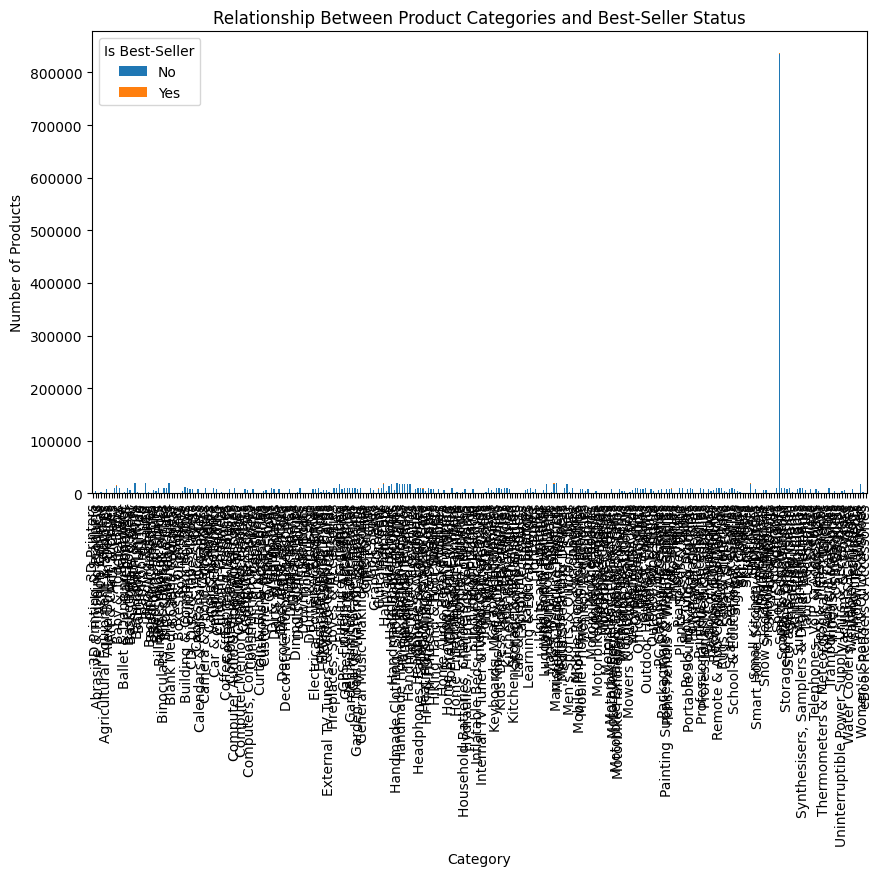

In [15]:
grouped_data = amazon_data.groupby(['category', 'isBestSeller']).size().unstack(fill_value=0)

grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6))

# Customize Chart
plt.title('Relationship Between Product Categories and Best-Seller Status')
plt.xlabel('Category')
plt.ylabel('Number of Products')
plt.legend(title='Is Best-Seller', labels=['No', 'Yes'])

# Display Chart
plt.show()

### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

**Objective**: Investigate how different product categories influence product prices.

0. **Preliminary Step: Remove outliers in product prices.**

	For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.
	
	*Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.*

In [30]:
# Filter out outliers
Q1 = amazon_data['price'].quantile(0.25)
Q3 = amazon_data['price'].quantile(0.75)

IQR = Q3 - Q1

filtered_amazon_data = amazon_data[~((amazon_data['price'] < (Q1 - 1.5 * IQR)) | (amazon_data['price'] > (Q3 + 1.5 * IQR)))]

filtered_amazon_data

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
...,...,...,...,...,...,...,...,...,...
2443646,2828589,B0CHSD7P2Q,"Motorbike Armour, Motorbike Clothing, Cycling ...",0.0,0,22.34,False,0,Motorbike Clothing
2443647,2828590,B0B7B8FNBQ,PROFIRST Waterproof Motorcycle 2 Piece Ladies ...,0.0,0,97.99,False,0,Motorbike Clothing
2443648,2828591,B0BD5FL5FB,Men’s Motorcycle Motorbike Biker Trousers Kevl...,0.0,0,52.99,False,0,Motorbike Clothing
2443649,2828592,B008OYLL4I,Texpeed Mens Motorcycle Motorbike Biker Trouse...,4.3,404,79.99,False,0,Motorbike Clothing


In [31]:
Q3 + 1.5 * IQR

99.99000000000001

1. **Violin Plots**:
    - Use a violin plot to visualize the distribution of `price` across different product `categories`. Filter out the top 20 categories based on count for better visualization.
    - Which product category tends to have the highest median price? Don't filter here by top categories.


/var/folders/rv/whttr0rs0h71ygvlwqb00mt00000gp/T/ipykernel_26116/1864781116.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = filtered_amazon_data[amazon_data['category'].isin(top_20_categories)]


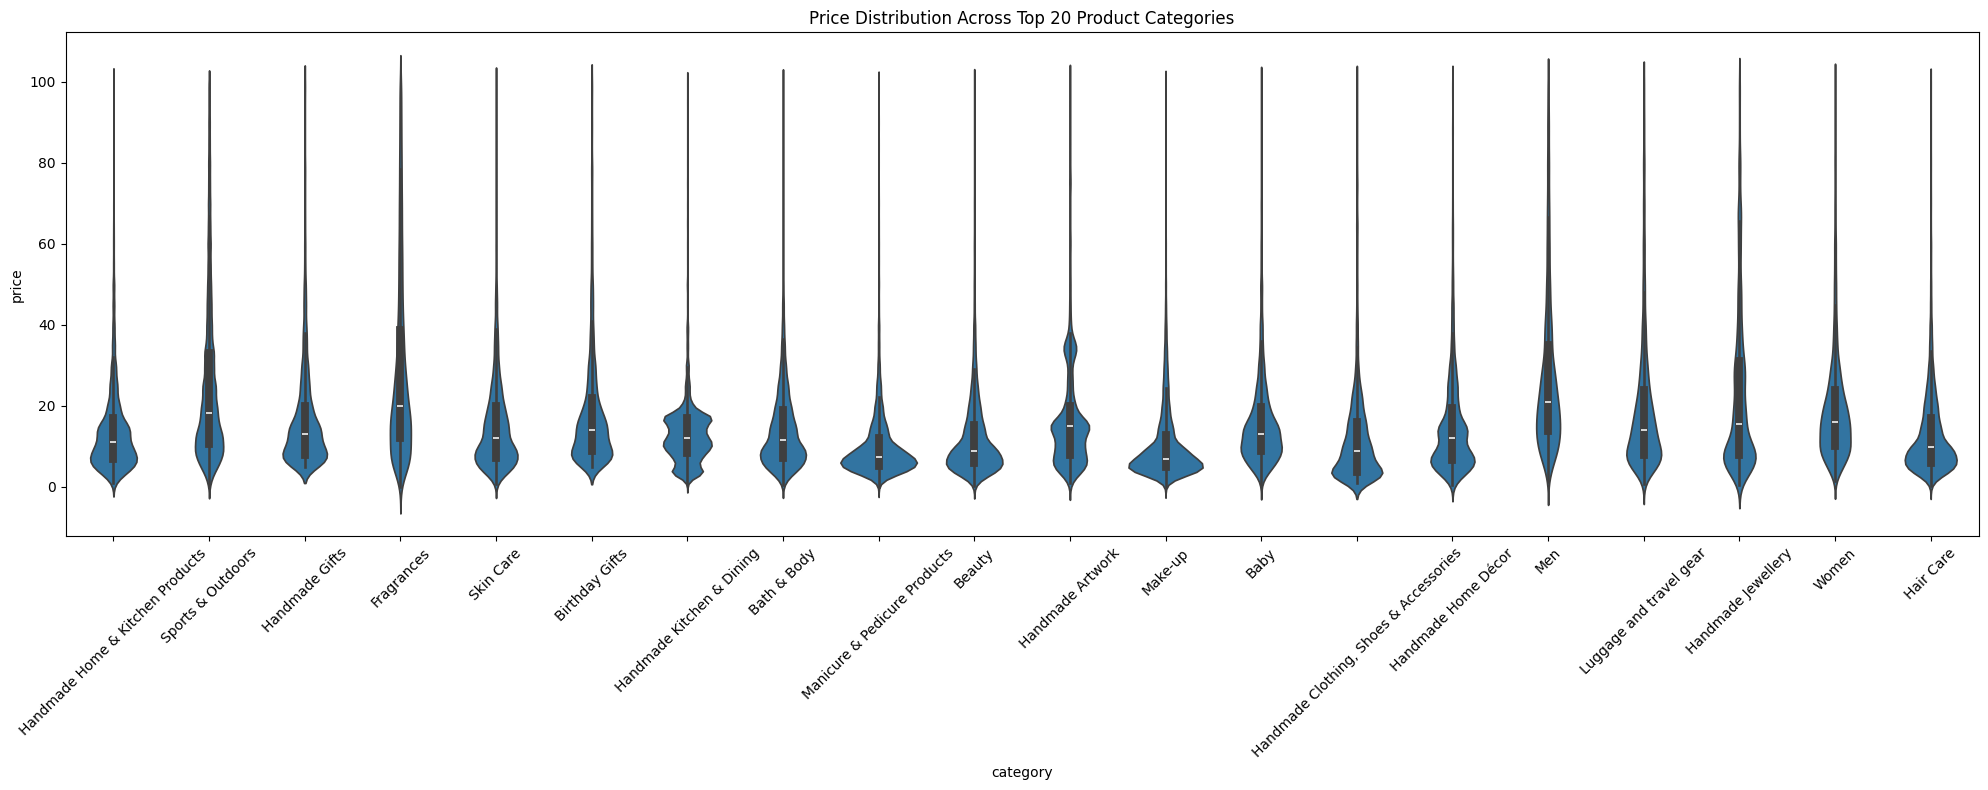

Category with the highest median price: Men


In [41]:
top_20_categories = filtered_amazon_data['category'].value_counts().head(20).index
filtered_df = filtered_amazon_data[amazon_data['category'].isin(top_20_categories)]

# Step 2: Create Violin Plot for Top 20 Categories
plt.figure(figsize=(20, 8))
sns.violinplot(x='category', y='price', data=filtered_df)
plt.xticks(rotation=45)
plt.title('Price Distribution Across Top 20 Product Categories')
plt.tight_layout()
plt.show()

# Step 3: Find Category with Highest Median Price
median_prices = filtered_df.groupby('category')['price'].median()
highest_median_price_category = median_prices.idxmax()

print(f"Category with the highest median price: {highest_median_price_category}")

2. **Bar Charts**:
    - Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
    - Which product category commands the highest average price? Don't filter here by top categories.


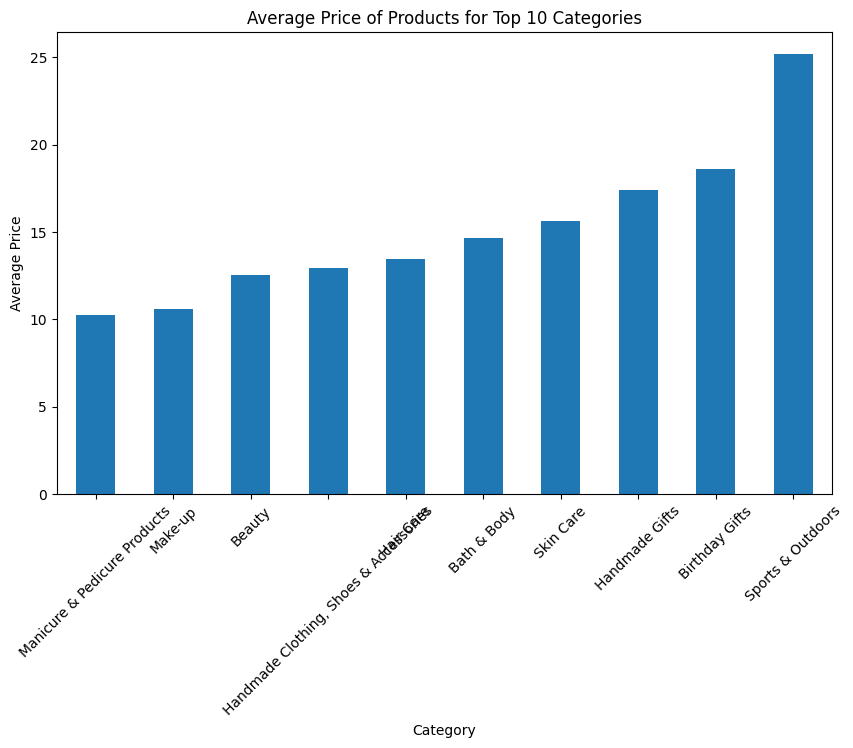

Category with the highest average price: Fragrances


In [23]:
top_10_categories = filtered_df['category'].value_counts().head(10).index
filtered_df_top_10 = filtered_df[filtered_df['category'].isin(top_10_categories)]

average_prices_top_10 = filtered_df_top_10.groupby('category')['price'].mean().sort_values()
plt.figure(figsize=(10, 6))
average_prices_top_10.plot(kind='bar')
plt.title('Average Price of Products for Top 10 Categories')
plt.xlabel('Category')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

# Find Category with Highest Average Price
average_prices_all = filtered_df.groupby('category')['price'].mean()
highest_average_price_category = average_prices_all.idxmax()

print(f"Category with the highest average price: {highest_average_price_category}")

3. **Box Plots**:
    - Visualize the distribution of product `ratings` based on their `category` using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
    - Which category tends to receive the highest median rating from customers? Don't filter here by top categories.


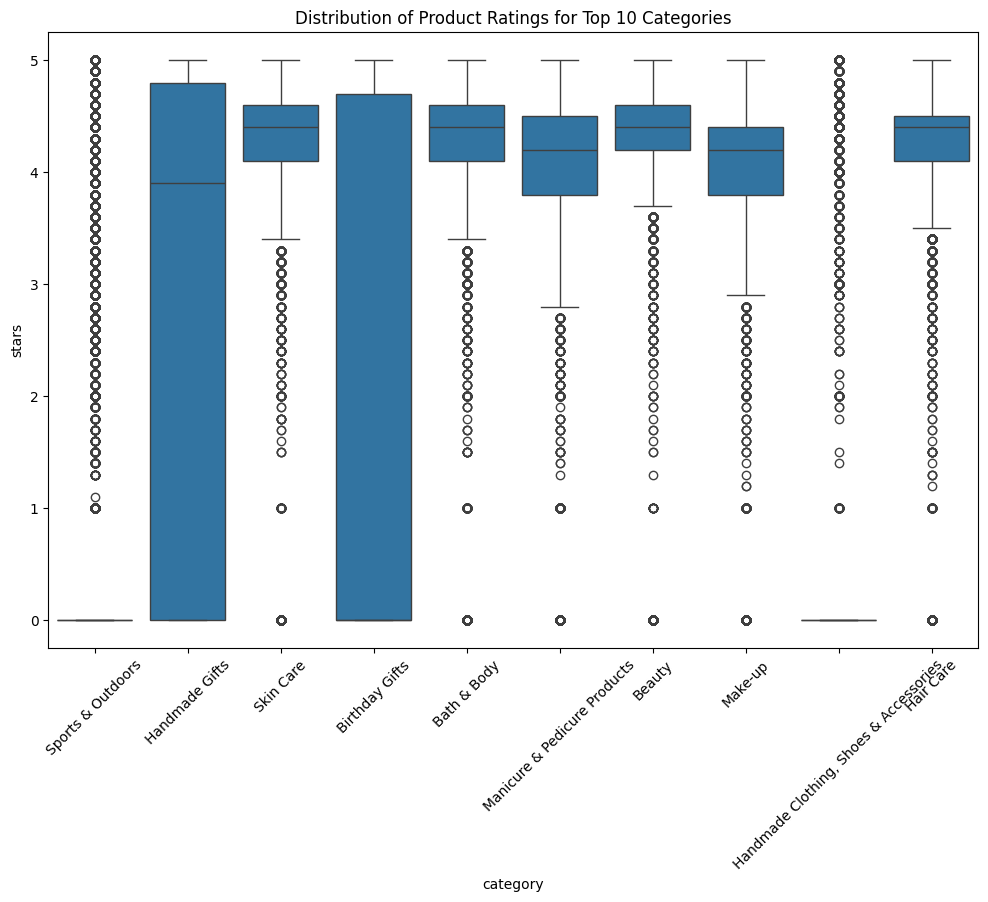

Category with the highest median rating: Bath & Body


In [43]:
top_10_categories = filtered_df['category'].value_counts().head(10).index
filtered_df = filtered_df[filtered_df['category'].isin(top_10_categories)]

# Create Side-by-Side Box Plots for Top 10 Categories
plt.figure(figsize=(12, 8))
sns.boxplot(x='category', y='stars', data=filtered_df)
plt.xticks(rotation=45)
plt.title('Distribution of Product Ratings for Top 10 Categories')
plt.show()

# Find Category with Highest Median Rating
median_ratings = filtered_df.groupby('category')['stars'].median()
highest_median_rating_category = median_ratings.idxmax()

print(f"Category with the highest median rating: {highest_median_rating_category}")


### Part 3: Investigating the Interplay Between Product Prices and Ratings

**Objective**: Analyze how product ratings (`stars`) correlate with product prices.

1. **Correlation Coefficients**:
    - Calculate the correlation coefficient between `price` and `stars`.
    - Is there a significant correlation between product price and its rating?
	

In [27]:
correlation_coefficient = amazon_data['price'].corr(amazon_data['stars'])

print(f"Correlation coefficient between price and stars: {correlation_coefficient}")

# Interpret Correlation
if correlation_coefficient > 0.5:
    print("There is a significant positive correlation between product price and its rating.")
elif correlation_coefficient < -0.5:
    print("There is a significant negative correlation between product price and its rating.")
else:
    print("There is no significant correlation between product price and its rating.")

Correlation coefficient between price and stars: -0.12490673262148386
There is no significant correlation between product price and its rating.


2. **Visualizations**:
    - Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
    - Use a correlation heatmap to visualize correlations between all numerical variables.
    - Examine if product prices typically follow a normal distribution using a QQ plot. 


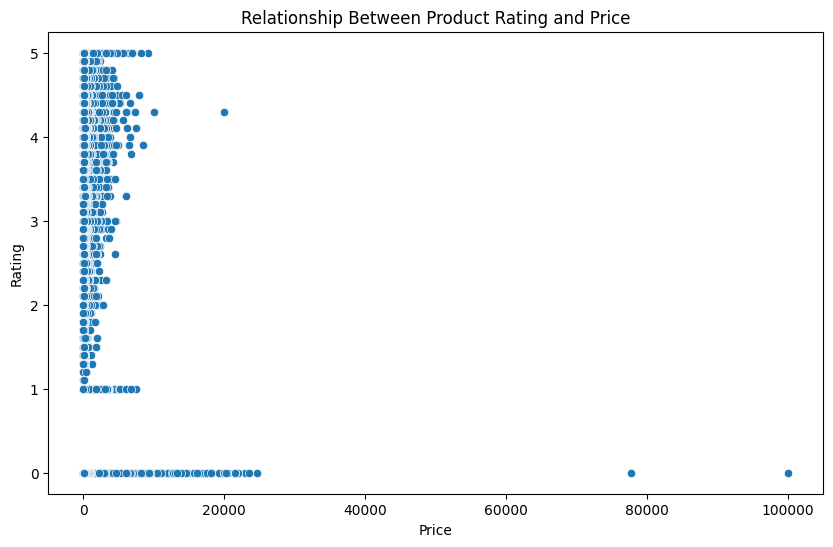

/var/folders/rv/whttr0rs0h71ygvlwqb00mt00000gp/T/ipykernel_26116/3615100879.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(amazon_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")


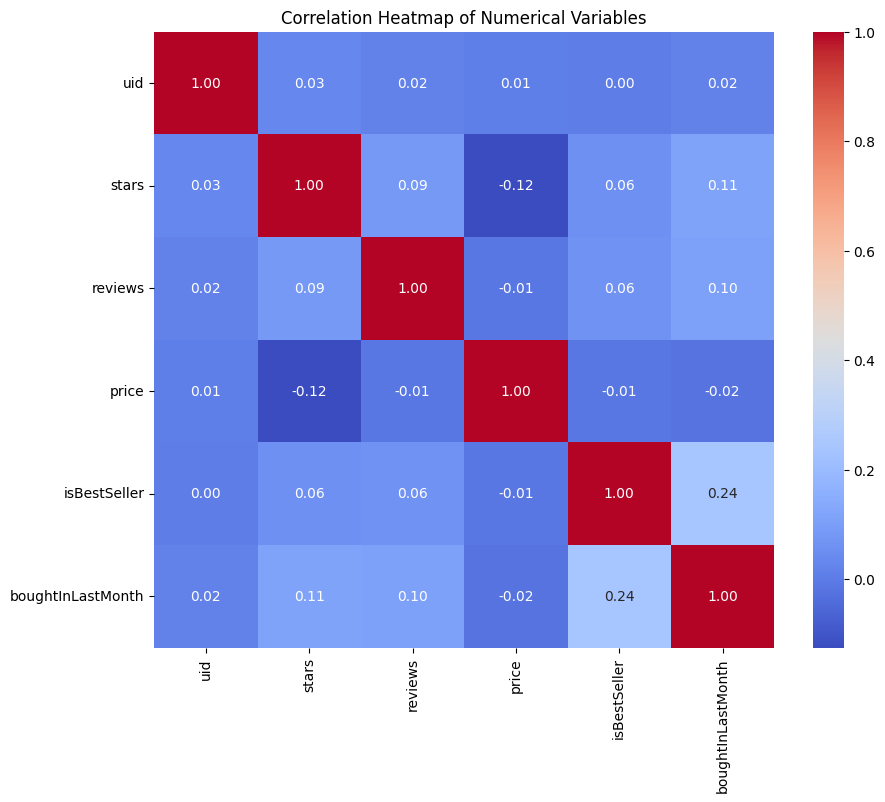

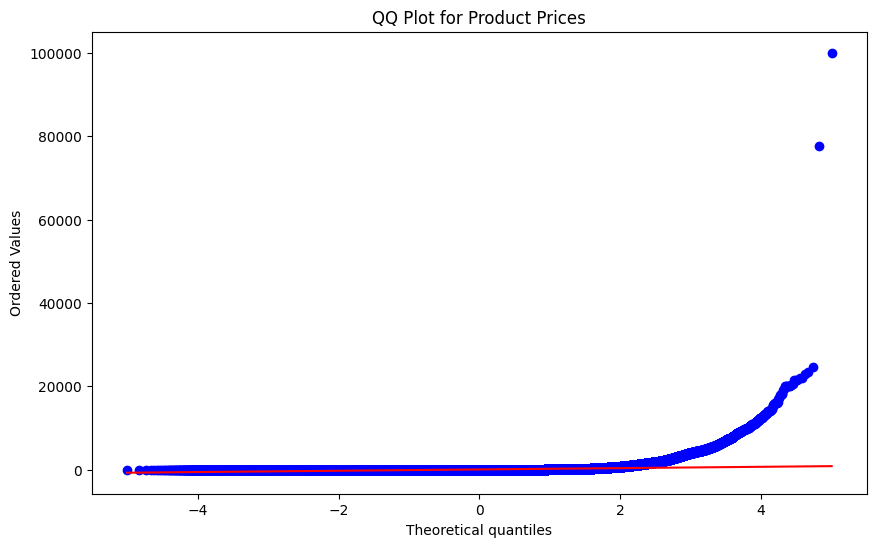

In [29]:
# Scatter Plot for Rating vs. Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='price', y='stars', data=amazon_data)
plt.title('Relationship Between Product Rating and Price')
plt.xlabel('Price')
plt.ylabel('Rating')
plt.show()

# Correlation Heatmap for Numerical Variables
plt.figure(figsize=(10, 8))
sns.heatmap(amazon_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

# QQ Plot for Product Prices
plt.figure(figsize=(10, 6))
probplot(amazon_data['price'], dist="norm", plot=plt)
plt.title('QQ Plot for Product Prices')
plt.show()

**Bonus**: 

- Do the same analysis without taking out the outliers. What are your insights?

